# Find unique ISBNs

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from common import LATEST_DUMP_FILENAME

from allisbns.dataset import (
    BinnedArray,
    CodeDataset,
    iterate_datasets,
    load_bencoded,
    unpack_data,
)
from allisbns.isbn import FIRST_ISBN, LAST_ISBN, TOTAL_ISBNS
from allisbns.plotting import BlockBinnedPlotter


%load_ext autoreload
%autoreload 2

## Load data

In [2]:
input_path = LATEST_DUMP_FILENAME
print(input_path)

aa_isbn13_codes_20251118T170842Z.benc.zst


In [3]:
with open(input_path, "rb") as f:
    input_data = load_bencoded(f)

In [4]:
all_collections = [x.decode() for x in input_data]
print(all_collections)

['airitibooks', 'bloomsbury', 'cadal_ssno', 'cerlalc', 'chinese_architecture', 'duxiu_ssid', 'edsebk', 'gbooks', 'goodreads', 'hathi', 'huawen_library', 'ia', 'isbndb', 'isbngrp', 'kulturpass', 'libby', 'md5', 'nexusstc', 'nexusstc_download', 'oclc', 'ol', 'ptpress', 'rgb', 'sciencereading', 'shukui', 'sklib', 'trantor', 'wanfang', 'zjjd']


## Get unique ISBNs

### Define target dataset 

In [5]:
target_collection = "rgb"

In [6]:
target_dataset = CodeDataset(unpack_data(input_data[target_collection.encode()]))
target_dataset

CodeDataset(array([     0, 137268,      1, ...,      1,    216,      1],
      shape=(1513749,), dtype=int32), bounds=(978000000000, 979867536810))

In [7]:
target_isbns = target_dataset.get_filled_isbns()
target_isbns

array([978000137268, 978000184777, 978000184988, ..., 979867505397,
       979867536593, 979867536810], shape=(2358168,))

### Test other datasets for unique ISBNs

In [8]:
test_collections = all_collections.copy()
test_collections.remove(target_collection)

datasets = iterate_datasets(input_data, collections=test_collections)

unique_mask = np.ones_like(target_isbns, dtype=bool)
for dataset in datasets:
    np.logical_and(unique_mask, ~dataset.check_isbns(target_isbns), out=unique_mask)

unique_mask

array([ True, False, False, ..., False, False, False], shape=(2358168,))

In [9]:
unique_isbns = target_isbns[unique_mask]
unique_isbns

array([978000137268, 978000293013, 978000392336, ..., 979598340177,
       979818424269, 979852212659], shape=(1084525,))

### Plot binned image

In [10]:
bin_size = 2000

In [11]:
empty_binned = BinnedArray(
    np.zeros(TOTAL_ISBNS // bin_size, dtype=np.int32),
    bin_size=bin_size,
)
empty_binned

BinnedArray(array([0, 0, 0, ..., 0, 0, 0], shape=(1000000,), dtype=int32), bin_size=2000)

In [12]:
bin_indices = np.unique((unique_isbns - FIRST_ISBN) // bin_size)
unique_binned = BinnedArray(np.zeros_like(empty_binned, bool), bin_size=bin_size)
unique_binned.bins[bin_indices] = True
unique_binned

BinnedArray(array([False, False, False, ..., False, False, False], shape=(1000000,)), bin_size=2000)

In [13]:
target_dataset = CodeDataset(target_dataset.codes, fill_to_isbn=LAST_ISBN)
target_dataset

CodeDataset(array([        0,    137268,         1, ...,       216,         1,
       132463189], shape=(1513750,)), bounds=(978000000000, 979999999999))

In [14]:
target_binned = target_dataset.bin(2000)
target_binned

BinnedArray(array([0, 0, 0, ..., 0, 0, 0], shape=(1000000,), dtype=int32), bin_size=2000)

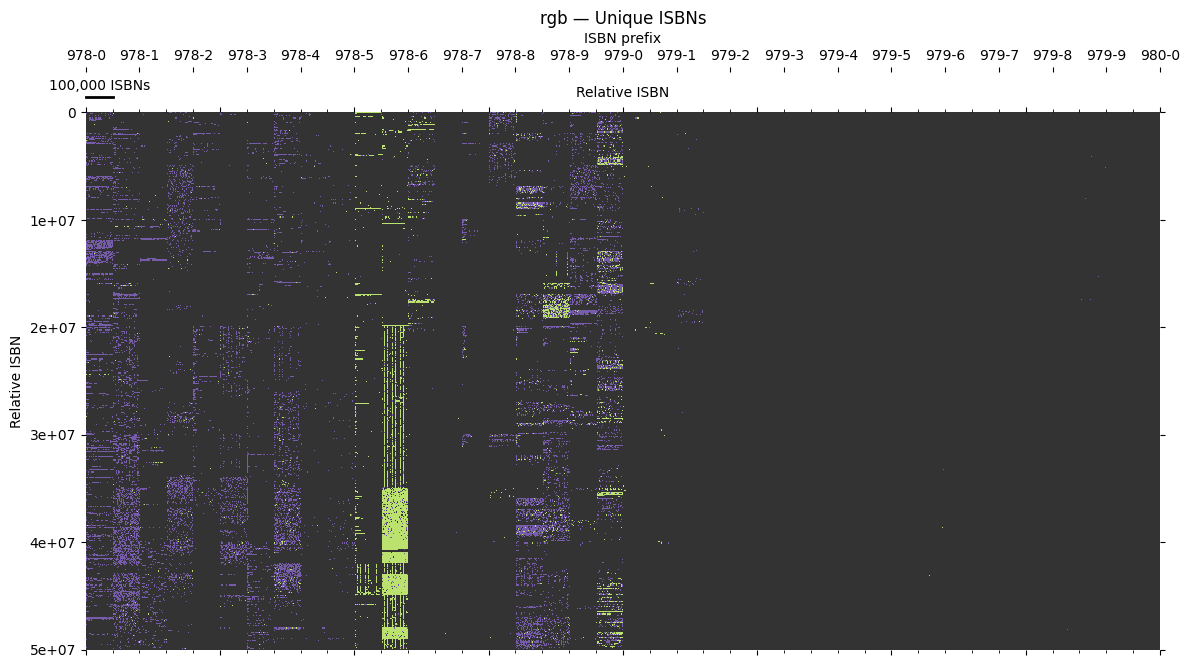

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

plotter = BlockBinnedPlotter(ax, bin_size=bin_size, aspect=2)

plot_kwargs = {"vmin": 0, "vmax": 1, "show_colorbar": False}
plotter.plot_bins(
    target_binned,
    colormap=mpl.colors.ListedColormap(["#956ee2"]),
    alpha=0.7,
    **plot_kwargs,
)
plotter.plot_bins(
    unique_binned, colormap=mpl.colors.ListedColormap(["#bbe26e"]), **plot_kwargs
)

ax.set_facecolor("0.2")

plt.title(f"{target_collection} — Unique ISBNs")

plt.tight_layout()
plt.show()